In [1]:
%matplotlib notebook
import sys
from pathlib import Path

SRC_ROOT_DIR_0 = '/g/wsl_projs/practical-astronomy'
SRC_ROOT_DIR_1 = '/g/wsl_projs/practical-astronomy/myastro/'
sys.path.insert(0, SRC_ROOT_DIR_0)
sys.path.insert(1, SRC_ROOT_DIR_1)

%load_ext autoreload
%autoreload 2


Bad key "text.kerning_factor" on line 4 in
/home/anybody/apps/anaconda3/envs/py37astro/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
from myastro.ephem import calc_orbits_data, EphemrisInput
from myastro.data_catalog import DF_BODYS, DF_COMETS, read_body_elms_for, read_comet_elms_for, CometElms, BodyElems
from myastro.data_catalog import APOFIS
import seaborn as sns
from toolz import concat, first
from myastro.graphics_util import OrbitsPlot
from numpy.linalg import norm
from scipy.integrate import solve_ivp    
from numpy.linalg import multi_dot, norm


In [54]:
# Two bodys 
G = 6.6742e-20 # Km^3/Kg*s^2
m1 = m2 = 1e26
def my_f(t, Y):        
    x1 = Y[0:3]
    x2 = Y[3:6]
    v1 = Y[6:9]
    v2 = Y[9:12]
    r_3  = pow(norm(x2-x1),3)
    acc1 = G*m2*(x2 - x1)/r_3
    acc2 = G*m1*(x1 - x2)/r_3
    return np.concatenate((v1,v2,acc1,acc2))

In [55]:
x0_1 = np.array([0,0,0])
v0_1 = np.array([10,20,30])
x0_2 = np.array([3000,0,0])
v0_2 = np.array([0,40,0])
Y0 = np.concatenate((x0_1,x0_2,v0_1, v0_2))

sol = solve_ivp(my_f, (0, 480), Y0, t_eval=list(range(0,480,4)), rtol = 1e-5)  

(12, 120)


In [6]:
# Two bodys with relative acceleration
G = 6.6742e-20 # Km^3/Kg*s^2
m1 = 5.974e24
R =  6378
m2 = 1000
x0 = np.array([8000,0,6000])
v0 = np.array([0, 7, 0])
t0 = 0 
tf = 4*3600
Y0 = np.concatenate((x0, v0))
mu = G*(m1+m2)

def my_f(t, Y):        
    x = Y[0:3]
    v = Y[3:6]
    r_3  = pow(norm(x),3)
    acc = -mu/r_3*x
    return np.concatenate((v, acc))

sol = solve_ivp(my_f, (t0, tf), Y0, t_eval=list(range(t0,tf,100)), rtol = 1e-10)  


In [15]:
# Three bodys
G = 6.6742e-20 # Km^3/Kg*s^2
m1 = m2 = m3 = 1e29
x1 = np.array([0,0])
x2 = np.array([300000,0])
x3 = 2*x2

v1 = np.array([0,0])
v2 = np.array([250,250])
v3 = np.array([0,0])

t0 = 0 
tf = 67000
Y0 = np.concatenate((x1, x2, x3, v1, v2, v3))


def my_f(t,Y):
    x1 = Y[0:2]
    x2 = Y[2:4]
    x3 = Y[4:6]
    
    v1 = Y[6:8]
    v2 = Y[8:10]
    v3 = Y[10:12]
    
    r12__3 = pow(norm(x1-x2),3)
    r23__3 = pow(norm(x2-x3),3)
    r13__3 = pow(norm(x1-x3),3)
    
    a1 = G*((m2*(x2-x1)/r12__3) + (m3*(x3-x1)/r13__3))
    a2 = G*((m1*(x1-x2)/r12__3) + (m3*(x3-x2)/r23__3))
    a3 = G*((m1*(x1-x3)/r13__3) + (m2*(x2-x3)/r23__3))
    
    return np.concatenate((v1,v2,v3,a1,a2,a3))
    
sol = solve_ivp(my_f, (t0, tf), Y0, t_eval=list(range(t0,tf,1000)), rtol = 1e-10)  
    

In [10]:
sol.y.shape

(12, 670)

### Other implementation

<IPython.core.display.Javascript object>


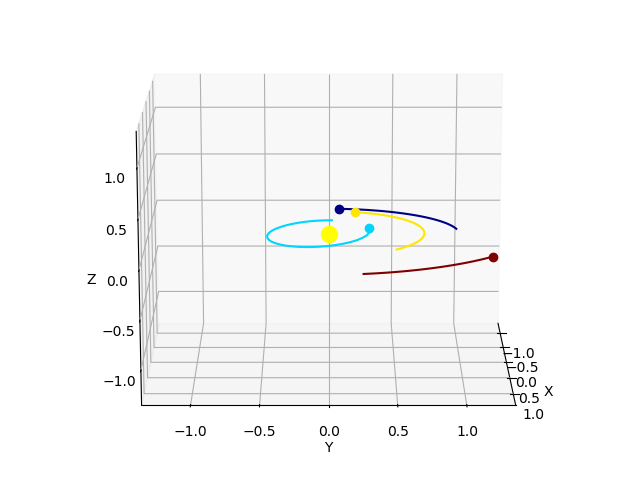

In [8]:
cols=['h_x','h_y','h_z']
# A 3d matrix with shape (a,b,c) where a=n_orbits, b=n_t_samples, c=3
x_t = np.array([df[cols].to_numpy() for df in dfs])

N_trajectories = len(dfs)

# Set up figure & 3D axis for animation
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
#ax.axis('off')

# choose a different color for each trajectory
colors = plt.cm.jet(np.linspace(0, 1, N_trajectories))

# set up lines and points
lines = sum([ax.plot([], [], [], '-', c=c) for c in colors], [])
pts = sum([ax.plot([], [], [], 'o', c=c) for c in colors], [])

LIMITS=(-1.3,1.3)

# prepare the axes limits
#ax.set_xlim((-30,30 ))
#ax.set_ylim((-30,30))
#ax.set_zlim((-30, 30))
ax.set_xlim(LIMITS)
ax.set_ylim(LIMITS)
ax.set_zlim(LIMITS)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# set point-of-view: specified by (altitude degrees, azimuth degrees)
ax.view_init(15, 0)
# SUN
ax.scatter3D(0,0,0, color='yellow', marker='o', lw=8, label='Sun')

# initialization function: plot the background of each frame
def init():
    for line, pt in zip(lines, pts):
        line.set_data([], [])
        line.set_3d_properties([])

        pt.set_data([], [])
        pt.set_3d_properties([])
    return lines + pts

# animation function.  This will be called sequentially with the frame number
def animate(i):
    #print (i)
    # we'll step two time-steps per frame.  This leads to nice results.
    i = (2 * i) % x_t.shape[1]

    for line, pt, xi in zip(lines, pts, x_t):
        x, y, z = xi[:i].T
        #print (x)
        #print (y)
        #print (z)
        line.set_data(x, y)
        line.set_3d_properties(z)

        pt.set_data(x[-1:], y[-1:])
        pt.set_3d_properties(z[-1:])

    #ax.view_init(30, 0.3 * i)
    fig.canvas.draw()
    return lines + pts

# instantiate the animator.
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=500, interval=500, blit=True, repeat=False)
#anim = animation.FuncAnimation(fig, animate, init_func=init, interval=500, blit=True, repeat=False)

# Save as mp4. This requires mplayer or ffmpeg to be installed
#anim.save('lorentz_attractor.mp4', fps=15, extra_args=['-vcodec', 'libx264'])

plt.show()


In [25]:
animate(2)

[-0.18314445 -0.21738337 -0.25134806 -0.28499862]
[-0.37991948 -0.39134127 -0.39518683 -0.39197985]
[0.5200483  0.49103405 0.46048123 0.42848397]
[1.37965144 1.3754605  1.37068102 1.36531696]


In [4]:
#animate (3)
len(orbs)

2

### Next Implementation

In [ ]:
orbs={}
orbs['m1'] = sol.y[:2,:].T
orbs['m2'] = sol.y[2:4,:].T
orbs['m3'] = sol.y[4:6,:].T
#orbs['G'] =  (m1*orbs['m1']+m2*orbs['m2'])/(m1+m2)
#orbs['m2'] =  orbs['m2']  - orbs['m1'] 
#orbs['G']  =  orbs['G']  - orbs['m1']
#orbs['m1'] =  orbs['m1']  - orbs['m1']

n_trajectories = len(orbs)

# Set up figure & 3D axis for animation
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
#ax.axis('off')

# choose a different color for each trajectory
colors = plt.cm.jet(np.linspace(0, 1, n_trajectories))

lines = []
pts = []
for i, (name, mtx) in enumerate(orbs.items()):
    lines.append(ax.plot([], [], [], '--', c=colors[i], label=name,lw=.7))
    pts.append(ax.plot([], [], [], 'o', c=colors[i]))
lines = list(concat(lines))
pts = list(concat(pts))

#LIMITS=(-1.3,1.3)
LIMITS=(-5000,5000)
# prepare the axes limits
ax.set_xlim((-10000,10000))
ax.set_ylim((10000,-10000))
ax.set_zlim((-10000,10000))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# SUN

#ax.set_aspect('equal')

#u = np.linspace(0, 2 * np.pi, 100)
#v = np.linspace(0, np.pi, 100)

#x = R * np.outer(np.cos(u), np.sin(v))
#y = R * np.outer(np.sin(u), np.sin(v))
#z = R * np.outer(np.ones(np.size(u)), np.cos(v))
#elev = 10.0
#rot = 80.0 / 180 * np.pi
#ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='b', linewidth=0, alpha=0.5)


ax.scatter3D(0,0,0, color='black', marker='o', lw=2, label='Origin')

#   set the legend, title and animation encoding type
ax.legend(loc='upper right', prop={'size': 9})
#ax.set_title("Tim-Sitze, Orbits of the Inner Planets")
#animation.writer = animation.writers['ffmpeg']

axtext = fig.add_axes([0.0,0.95,0.1,0.05])
# turn the axis labels/spines/ticks off
axtext.axis("off")

time = axtext.text(0.5,0.5, sol.t[0], ha="left", va="top")

# initialization function: plot the background of each frame
def init():
    for line, pt in zip(lines, pts):
        line.set_data([], [])
        line.set_3d_properties([])

        pt.set_data([], [])
        pt.set_3d_properties([])
    return lines + pts

def animate(i):
    for line, pt, mtx in zip(lines, pts, orbs.values()):
        xs = mtx[0:i,0]        
        ys = mtx[0:i,1]
        #zs = mtx[0:i,2]
        zs = np.zeros(4)
        
        line.set_data(xs, ys)
        line.set_3d_properties(zs)
        
        x = xs[-1:]
        y = ys[-1:]
        #z = zs[-1:]        
        z = 0
        pt.set_data(x, y)
        pt.set_3d_properties(z)
        
        time.set_text(sol.t[i])

    #ax.view_init(30, 0.3 * i)
    fig.canvas.draw()
    return lines + pts
    
# instantiate the animator.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(sol.t), interval=1000, blit=False, repeat=False)
plt.show()

In [16]:
h = np.cross(r,v)
norm(h)

94000.5

In [18]:
np.rad2deg(np.arccos(r/norm(r)))

array([52.12501635, 37.87498365, 90.        ])

### Current Implementation

### 2D Animation

<IPython.core.display.Javascript object>


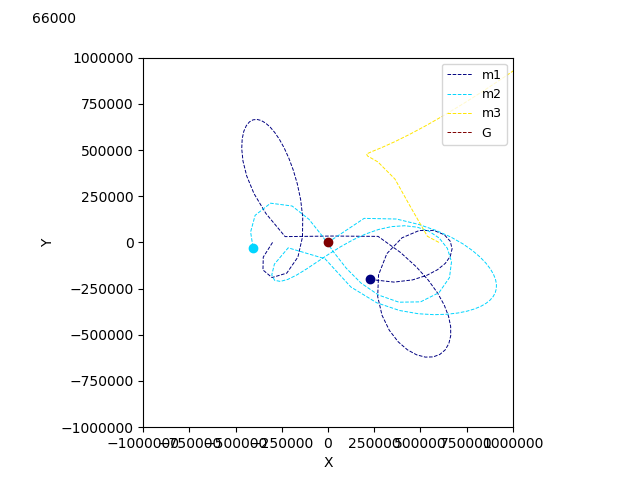

In [20]:
orbs={}
orbs['m1'] = sol.y[:2,:].T
orbs['m2'] = sol.y[2:4,:].T
orbs['m3'] = sol.y[4:6,:].T
orbs['G'] =  (m1*orbs['m1']+m2*orbs['m2']+m3*orbs['m3'])/(m1+m2+m3)

# With respect G
orbs['m1'] =  orbs['m1']  - orbs['G']
orbs['m2'] =  orbs['m2']  - orbs['G'] 
orbs['G']  =  orbs['G']  - orbs['G']


n_trajectories = len(orbs)

# Set up figure & 3D axis for animation
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.axis('off')
#IMITS=(-5000,5000)
# prepare the axes limits
max_limit=1000000
ax.set_xlim((-max_limit, max_limit))
ax.set_ylim((-max_limit,max_limit))
ax.set_xlabel("X")
ax.set_ylabel("Y")

# choose a different color for each trajectory
colors = plt.cm.jet(np.linspace(0, 1, n_trajectories))

lines = []
pts = []
for i, (name, mtx) in enumerate(orbs.items()):
    lines.append(ax.plot([], [], '--', c=colors[i], label=name,lw=.7))
    pts.append(ax.plot([], [], 'o', c=colors[i]))
lines = list(concat(lines))
pts = list(concat(pts))

# set the legend, title and animation encoding type
ax.legend(loc='upper right', prop={'size': 9})

axtext = fig.add_axes([0.0,0.95,0.1,0.05])
# turn the axis labels/spines/ticks off
axtext.axis("off")

time = axtext.text(0.5,0.5, sol.t[0], ha="left", va="top")

# initialization function: plot the background of each frame
def init():
    for line, pt in zip(lines, pts):
        line.set_data([], [])
        pt.set_data([], [])
    return lines + pts

def animate(i):
    for line, pt, mtx in zip(lines, pts, orbs.values()):
        xs = mtx[0:i,0]        
        ys = mtx[0:i,1]
        
        line.set_data(xs, ys)
                
        x = xs[-1:]
        y = ys[-1:]
        pt.set_data(x, y)
        
        time.set_text(sol.t[i])

    #ax.view_init(30, 0.3 * i)
    return lines + pts       

# instantiate the animator.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(sol.t), interval=1000, blit=False, repeat=False)
plt.show()

<IPython.core.display.Javascript object>


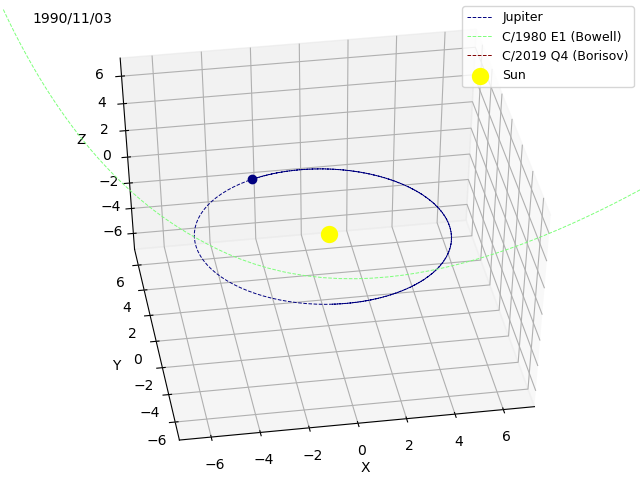

In [63]:
fig = plt.figure()
LIMITS=(-7,7)
orbs_plot = OrbitsPlot(orbs, date_refs, fig, LIMITS)
anim = animation.FuncAnimation(fig, orbs_plot.animate, init_func=orbs_plot.init, frames=len(date_refs), interval=1000, blit=False, repeat=False)
plt.show()


In [25]:
df = DF_COMETS

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3633 entries, 0 to 3632
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    3633 non-null   object 
 1   Epoch   3633 non-null   float64
 2   q       3633 non-null   float64
 3   e       3633 non-null   float64
 4   i       3633 non-null   float64
 5   w       3633 non-null   float64
 6   Node    3633 non-null   float64
 7   Tp      3633 non-null   object 
 8   Ref     3633 non-null   object 
dtypes: float64(6), object(3)
memory usage: 255.6+ KB


In [29]:
df.sort_values('e',ascending=False)[:3]

,Name,Epoch,q,e,i,w,Node,Tp,Ref
3591,C/2019 Q4 (Borisov),59061.0,2.006624,3.356191,44.05263,209.12461,308.14892,20191208.54489,JPL 52
3632,C/2020 J1 (SONEAR),58972.0,3.207467,1.063884,142.17320,344.64352,227.81652,20210407.54326,JPL 1
1075,C/1980 E1 (Bowell),44972.0,3.363938,1.057732,1.66171,135.08262,114.55820,19820312.28714,JPL 5


<IPython.core.display.Javascript object>


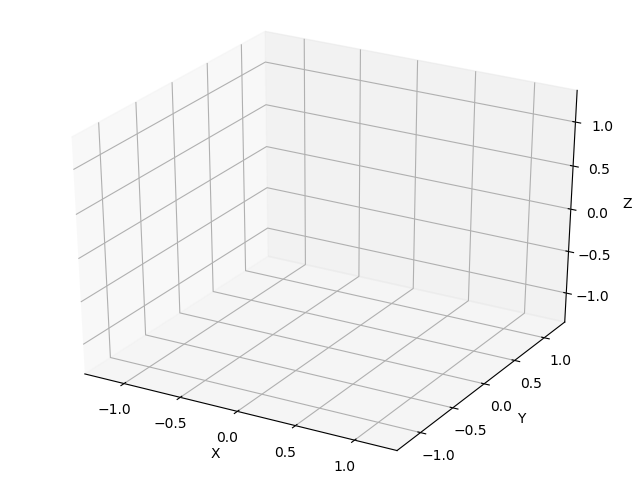

In [9]:
# Set up figure & 3D axis for animation
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
#ax.axis('off')

# choose a different color for each trajectory
colors = plt.cm.jet(np.linspace(0, 1, N_trajectories))


In [10]:
colors

array([[0.        , 0.        , 0.5       , 1.        ],
       [0.        , 0.15882353, 1.        , 1.        ],
       [0.        , 0.83333333, 1.        , 1.        ],
       [0.49019608, 1.        , 0.47754586, 1.        ],
       [1.        , 0.90123457, 0.        , 1.        ],
       [1.        , 0.27668845, 0.        , 1.        ],
       [0.5       , 0.        , 0.        , 1.        ]])

In [11]:
lines = []
pts = []
for i, (name, mtx) in enumerate(orbs.items()):
    lines.append(ax.plot([], [], [], '-', c=colors[i],label=name))
    pts.append(ax.plot([], [], [], 'o', c=colors[i]))
    #ax.plot3D(mtx[:,0],mtx[:,1],mtx[:,2], c=colors[i], lw=.75, label=name)
lines = list(concat(lines))
pts = list(concat(pts))
    
    

In [12]:
LIMITS=(-1.3,1.3)
# prepare the axes limits
ax.set_xlim(LIMITS)
ax.set_ylim(LIMITS)
ax.set_zlim(LIMITS)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

Text(0.0863224683098014, 0.011565017836136133, 'Z')

In [13]:
# initialization function: plot the background of each frame
def init():
    for line, pt in zip(lines, pts):
        line.set_data([], [])
        line.set_3d_properties([])

        pt.set_data([], [])
        pt.set_3d_properties([])
    return lines + pts


In [14]:
def animate(i):
    for line, pt, mtx in zip(lines, points, orbs.values()):
        xs = mtx[0:i,0]
        ys = mtx[0:i,1]
        zs = mtx[0:i,2]
        line.set_data(xs, ys)
        line.set_3d_properties(zs)

        x = xs[-1:]
        y = ys[-1:]
        z = zs[-1:]
        pt.set_data(x, y)
        pt.set_3d_properties(z)

        #ax.view_init(30, 0.3 * i)
        fig.canvas.draw()
        return lines + pts


In [15]:
anim = animation.FuncAnimation(fig, animate, init_func=init, interval=500, blit=True, repeat=False)



In [16]:
plt.show()

In [80]:
i=3
xyz[0:i,0] #  x
xs =  xyz[0:i,0] 

In [81]:
xs[-1:]

array([7])

In [78]:
xs

array([1, 4])

In [17]:
# first plot the constants to be used in our plots
# plot the sun at the origin
ax.scatter3D(0,0,0, color='yellow', marker='o', lw=8, label='Sun')

# plot the orbit of mercury
ax.plot3D(merc_orb[:,0],merc_orb[:,1],merc_orb[:,2], color='gray', lw=.75, label='Mercury')

# plot the prbit of Venus
ax.plot3D(ven_orb[:,0],ven_orb[:,1],ven_orb[:,2], color='orange', lw=.75, label='Venus')

# plot the orbit of the Earth
ax.plot3D(earth_orb[:,0],earth_orb[:,1],earth_orb[:,2], color='blue', lw=.75, label='Earth')

# plot the orbit of Mars
ax.plot3D(mars_orb[:,0],mars_orb[:,1],mars_orb[:,2], color='red', lw=.75, label='Mars')


# get the particles 3d plots. Initially empty
merc_particle, = plt.plot([],[],[], marker='.', color='gray', lw=2)
ven_particle, = plt.plot([],[],[], marker='.', color='orange', lw=2)
earth_particle, = plt.plot([],[],[], marker='.', color='blue', lw=2)
mars_particle, = plt.plot([],[],[], marker='.', color='red', lw=2)

In [18]:
lines

In [ ]:
cols=['h_x','h_y','h_z']
# A 3d matrix with shape (a,b,c) where a=n_orbits, b=n_t_samples, c=3
x_t = np.array([df[cols].to_numpy() for df in dfs])

N_trajectories = len(dfs)

# Set up figure & 3D axis for animation
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
#ax.axis('off')

# choose a different color for each trajectory
colors = plt.cm.jet(np.linspace(0, 1, N_trajectories))

# set up lines and points
lines = sum([ax.plot([], [], [], '-', c=c)
             for c in colors], [])
pts = sum([ax.plot([], [], [], 'o', c=c)
           for c in colors], [])

LIMITS=(-1.3,1.3)

# prepare the axes limits
#ax.set_xlim((-30,30 ))
#ax.set_ylim((-30,30))
#ax.set_zlim((-30, 30))
ax.set_xlim(LIMITS)
ax.set_ylim(LIMITS)
ax.set_zlim(LIMITS)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# set point-of-view: specified by (altitude degrees, azimuth degrees)
ax.view_init(15, 0)
# SUN
ax.scatter3D(0,0,0, color='yellow', marker='o', lw=8, label='Sun')

# initialization function: plot the background of each frame
def init():
    for line, pt in zip(lines, pts):
        line.set_data([], [])
        line.set_3d_properties([])

        pt.set_data([], [])
        pt.set_3d_properties([])
    return lines + pts

# animation function.  This will be called sequentially with the frame number
def animate(i):
    # we'll step two time-steps per frame.  This leads to nice results.
    i = (2 * i) % x_t.shape[1]

    for line, pt, xi in zip(lines, pts, x_t):
        x, y, z = xi[:i].T
        line.set_data(x, y)
        line.set_3d_properties(z)

        pt.set_data(x[-1:], y[-1:])
        pt.set_3d_properties(z[-1:])

    #ax.view_init(30, 0.3 * i)
    fig.canvas.draw()
    return lines + pts

# instantiate the animator.
#anim = animation.FuncAnimation(fig, animate, init_func=init,frames=500, interval=500, blit=True, repeat=False)
anim = animation.FuncAnimation(fig, animate, init_func=init, interval=500, blit=True, repeat=False)

# Save as mp4. This requires mplayer or ffmpeg to be installed
#anim.save('lorentz_attractor.mp4', fps=15, extra_args=['-vcodec', 'libx264'])

plt.show()


In [20]:
list1=['a','b','c']
sum(list1,[''])

TypeError: can only concatenate list (not "str") to list

### Exammple 2.12 (pg 105)

In [5]:
pq = np.array([7000,9000])
vpq = np.array([-3.3472,9.1251])

In [13]:
# Angular momentum
h = np.cross(pq,vpq)
# r dot p^ = r*cos*theta
p = np.array([1.0,0])
#theta is the true anomaly
cos_theta = pq.dot(p)/norm(pq)
# e can found from the orbit formula:


0.6139406135149205


### Example 2.13 (Pg 111)

In [16]:
R0 = np.array([8182.4,-6865.9])
V0 = np.array([0.47572,8.8116])
A_theta= np.deg2rad(120)

In [18]:
r0 = norm(R0)
v0 = norm(V0)

In [20]:
r0,v0

(10681.397500795483, 8.82443222413771)

In [22]:
v_rad0 = R0.dot(V0)/norm(R0)
v_rad0

-5.2995905365177425

In [24]:
h0 = np.cross(R0,V0)
h0

array(75366.281788)

### Algorithm 3.4 Pg 174

In [ ]:
def kepler_u(mu, dt, ro, vro, a):
    x = np.sqrt(mu)*np.abs(a)*dt
    
    